# Hello Tables!
### Processing tabular data with Python, practical introduction

By: ![](https://avatars1.githubusercontent.com/u/588857?v=3&s=120)
- [Wojtek Bederski](https://wuub.net/)  
- twitter: [@wuub](https://twitter.com/wuub) 
- github: [wuub](https://github.com/wuub) 


# Outline

1. How this talk will be given? (ground rules)
2. What is tabular data?
3. Working with data using stdlib.
  1. How to read csv/tsv files
 ?
  2. What can you do with it?
  3. How to write my own CSV?
4. Going outside of stdlib
  1. Reading other common formats 
  2. Using convinience libraries.
5. Bonus



# How this talk will be given? 

1. We will talk about technical details of dealing with common tabular data formats. To see how easy it is to get started :) 
2. Take a quick look at Python's Standard library `csv` module (for the times when you wan to stay in stdlib)
2. We will look at some external libraries that lets us deal with the same files in a bit more pleasant way.
2. We will move very quickly (15minutes limit :)), but you don't have to remember everything, you can go trough this examples later. 
2. We will hold questions **after** the talk. Use sli.do or write your question down.
2. If you know what a spreasheet is, but didn't read one in Python yet, this talk is for **you** :)


# What is tabular data?

A rectangular table.
List of rows with common attributes.

|Kierunek|Typ |Data startu        |Data konca         |Czas trwania   |Do/Od      |Cena|
|--------|----|-------------------|-------------------|---------------|-----------|----|
|-|data|2017-05-31 20:32:55|-|450125834|-|0.0|
|outgoing|call|2017-05-31 19:16:05|2017-05-31 19:17:22|77             |48666666666|0.0 |
|incoming|call|2017-05-31 19:14:11|2017-05-31 19:14:11|-              |połączenie przychodzące|0.0|
|incoming|call|2017-05-31 15:14:52|2017-05-31 15:15:07|15             |połączenie przychodzące|0.0|



## Where are we using it?

And it's everywhere:

- spreadsheets (obviously)
- database tables (yes, rows and columns)
- html tables (not always strictly conforming to our definition)
- structured logs (file with lots of rows of JSON)
- sensor readouts 
- billing statements



## Not so obvious things can be represented as tabular data.

- periodic table of elements (eg. https://github.com/andrejewski/periodic-table/blob/master/data.csv)
- pictures/bitmaps
- exports and backups of commonly used tools
- maps data (POI) (np. http://ump.waw.pl/)
- input data for bulk operations (creating user accounts, bulk orders) (eg. https://support.google.com/a/answer/40057?hl=en)

## Also machine learning/data science

- pretty much built on tabular data
- but a whole different topic, that would need several presentations (we will not talk about this, just know it exists)

# Dictionary

Probably pretty obvious :) 

| column 1, header | column 2, header | column 3, header |
|------------------|------------------|------------------|
| row 1, cell 1    | row 1, cell 2    | row 1, cell 3    |
| row 2, cell 1    | row 2, cell 2    | row 2, cell 3    |
| row 3, cell 1    | row 3, cell 2    | row 3, cell 3    |


# How to read csv/tsv files data?

In [1]:
# How does a Tab Separated File / Comma Separated File look like?
with open('data/city_list.txt', encoding='windows-1252') as f:
    print(f.read(256).upper())

ID	NM	LAT	LON	COUNTRYCODE
819827	RAZVILKA	55.591667	37.740833	RU
524901	MOSCOW	55.752220	37.615555	RU
1271881	FIROZPUR JHIRKA	27.799999	76.949997	IN
1283240	KATHMANDU	27.716667	85.316666	NP
703448	KIEV	50.433334	30.516666	UA
1282898	POKHARA	28.233334	83.98


In [2]:
### DON'T DO THIS, IT WILL WORK SOMETIMES, AND 
### EVENTUALLY BLOW UP ON REAL WORLD DOCUMENTS

with open('data/city_list.txt', encoding='windows-1252') as f:
    f.readline()  # skip header
    print(f.readline().strip().split('\t'))  # BAD, DON'T DO THIS!


['819827', 'Razvilka', '55.591667', '37.740833', 'RU']


## Why?

It will hurt you if any of the cells uses separator in its content:

`819827,Razvilka,55.591667,37.740833,RU\n`

can also look like this

`4140963,"Washington, D. C.",38.895111,-77.036369,US`

Where the second comma is **quoted**, this means it's a part of second column, and **NOT** a separator.

**Don't** try to handle it yourself. **Use** Python's standard library or one of the **3rd party** libraries.

# How to read CSV/TSV file correctly?

In [3]:
import csv

stations = []
with open('data/city_list.txt', encoding="windows-1252") as f:
    dialect = csv.Sniffer().sniff(f.read(1024))  # automatically detect a dialect
    f.seek(0)  # reset file to the begginig
    reader = csv.DictReader(f, dialect=dialect)
    for station in reader:
        # we need to do type conversion by hand,
        # all fields are read as strings 
        station['id'] = int(station['id'])
        station['lat'] = float(station['lat'])
        station['lon'] = float(station['lon'])
        stations.append(station)

stations[12417]

OrderedDict([('id', 2516372),
             ('nm', 'Xeraco,Jaraco'),
             ('lat', 39.033329),
             ('lon', -0.21667),
             ('countryCode', 'ES')])

### Notes:

Our city_list.txt file is rellatively small for a modern computer (3MB), so we can read all the rows at once
and convert them into a list. 

If you're working with larger files (tens of megabytes or more) think if you can process rows one at a time, and not store them in memory. 

```python
top_price = -1
for row in reader:
    # do something with your row here, and continue
    print(row['id'])
    top_price = max(top_price, row['price'])
    ...
print(top_price)
```

# Once you load it, what can we do with the data?

In [4]:
# Find all the countries. Naive way.

countries1 = set()
for s in stations:
    countries1.add(s['countryCode'])

len(countries1)

244

In [5]:
# More Pythonic

countries2 = {s['countryCode'] for s in stations}  # set comprehension
len(countries2)

244

In [6]:
# Find station called Warsaw in Poland

next(s for s in stations if s['nm'] == "Warsaw" and s['countryCode'] == 'PL')

OrderedDict([('id', 756135),
             ('nm', 'Warsaw'),
             ('lat', 52.229771),
             ('lon', 21.01178),
             ('countryCode', 'PL')])

In [7]:
# sort stations by lat, then lon
import operator
sorted(stations, key=operator.itemgetter('lat', 'lon'))[:5]  

[OrderedDict([('id', 3833367),
              ('nm', 'Ushuaia'),
              ('lat', -54.799999),
              ('lon', -68.300003),
              ('countryCode', 'AR')]),
 OrderedDict([('id', 3426466),
              ('nm', 'Grytviken'),
              ('lat', -54.281109),
              ('lon', -36.509201),
              ('countryCode', 'GS')]),
 OrderedDict([('id', 3874787),
              ('nm', 'Punta Arenas'),
              ('lat', -53.150002),
              ('lon', -70.916672),
              ('countryCode', 'CL')]),
 OrderedDict([('id', 3874958),
              ('nm', 'Puerto Natales'),
              ('lat', -51.723629),
              ('lon', -72.48745),
              ('countryCode', 'CL')]),
 OrderedDict([('id', 3426691),
              ('nm', 'Stanley'),
              ('lat', -51.700001),
              ('lon', -57.849998),
              ('countryCode', 'FK')])]

In [8]:
# Count the number of stations per country, by hand, and get 10 most common

pc1 = dict()
for s in stations:
    country = s['countryCode']
    pc1[country] = pc1.get(country, 0) + 1 

sorted_by_count_desc = sorted(pc1.items(), key=operator.itemgetter(1), reverse=True)
sorted_by_count_desc[:10]


[('US', 11731),
 ('DE', 5024),
 ('FR', 4822),
 ('IT', 4573),
 ('PH', 4150),
 ('RU', 3893),
 ('IN', 3337),
 ('RO', 2385),
 ('GB', 2277),
 ('ES', 2037)]

In [9]:
# Using standard library Counter
# https://docs.python.org/3/library/collections.html#collections.Counter
from collections import Counter  
per_country_counter = Counter(s['countryCode'] for s in stations)

per_country_counter.most_common(10)

[('US', 11731),
 ('DE', 5024),
 ('FR', 4822),
 ('IT', 4573),
 ('PH', 4150),
 ('RU', 3893),
 ('IN', 3337),
 ('RO', 2385),
 ('GB', 2277),
 ('ES', 2037)]

In [10]:
import statistics  # https://docs.python.org/3/library/statistics.html

values = per_country_counter.values()
{
    "mean": statistics.mean(values),
    "median": statistics.median(values),
    "variance": statistics.variance(values),
}


{'mean': 303.5696721311475, 'median': 38.0, 'variance': 1083365.9251669704}

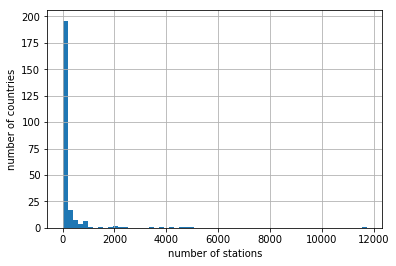

In [11]:
# Matplotlib will be discussed in some future presentation :)
# draw a histogram

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(list(per_country_counter.values()), 60)
plt.xlabel("number of stations")
plt.ylabel("number of countries")
plt.grid()

# Write a simple CSV

Not a problem, use `csv` package again.

In [12]:
import io
import csv

buf = io.StringIO()  # you can also open a file

writer = csv.DictWriter(f=buf, dialect=csv.excel, fieldnames=['first_name', 'last_name', 'age', 'address'])
writer.writeheader()

writer.writerow({'first_name': "Wojtek", 'last_name': "Bederski", 'age': 33, 'address': "Hoża 51, 00-681 Warsaw, Poland"})
writer.writerow({'first_name': "Asia", 'last_name': "Tustanowska", 'age': 18, 'address': "Pl. Europejski 1, Warsaw, Poland"})
buf.flush()

buf.seek(0)
print(buf.read())

# Note the automatic quoting, you don't have to worry about it

first_name,last_name,age,address
Wojtek,Bederski,33,"Hoża 51, 00-681 Warsaw, Poland"
Asia,Tustanowska,18,"Pl. Europejski 1, Warsaw, Poland"



# Pretty straightforward, right?

# Access other formats using 3rd party libraries

## Pick the one you like, both are good

```shell
(virtualenv) $ pip install tablib, rows

```

 * http://turicas.info/rows/  (very pleasant to use, stronger than stdlib)
 * http://docs.python-tablib.org (a bit less magic, but somewhat harder to use)
 



In [13]:
import tablib
sample_dataset = tablib.Dataset()
sample_dataset.load(open('./data/city_list_sample.xlsx', 'rb').read(), format='xlsx')

display(sample_dataset.headers)
display(sample_dataset[10])  # this is a tuple, you need to remember column index (but types converted automatically)

['id', 'nm', 'lat', 'lon', 'countryCode']

(529368, 'Marfino', 55.702778, 37.382221, 'RU')

In [14]:
from collections import Counter
tablib_countries = Counter(sample_dataset.get_col(4))

# this is from different document (sample) so it will not be the same
tablib_countries.most_common(10)

[('RU', 1625),
 ('AU', 226),
 ('US', 214),
 ('IT', 157),
 ('GB', 133),
 ('ES', 120),
 ('DE', 120),
 ('CA', 87),
 ('IN', 83),
 ('UA', 83)]

In [15]:
# You can easily create a HTML table
print(sample_dataset.html[:240] + " ... ")

<table>
<thead>
<tr><th>id</th>
<th>nm</th>
<th>lat</th>
<th>lon</th>
<th>countryCode</th></tr>
</thead>
<tr><td>819827</td>
<td>Razvilka</td>
<td>55.591667</td>
<td>37.740833</td>
<td>RU</td></tr>
<tr><td>524901</td>
<td>Moscow</td>
<td>55 ... 


# ... or export to a number of other different formats

```python
with open("sample.xls", 'wb') as f:
    f.write(sample_dataset.xls)
    # or sample_dataset.xlsx  Microsoft Office (new)
    # or sample_dataset.csv  
    # or sample_dataset.tsv
    # or sample_dataset.yaml
    # or sample_dataset.ods  Open Office
    # or sample_dataset.latex
    # or sample_dataset.json
    # or sample_dataset.html  
```

# rows

It's so niiice :) 

In [16]:
# rows

import rows
rows_table = rows.import_from_xlsx('./data/city_list_sample.xlsx')
rows_table

<rows.Table (from xlsx) 5 fields, 3568 rows>

In [17]:
display(rows_table.field_names)
display(rows_table.field_types) # automatic type detection. :yay:
display(rows_table[10])
display(rows_table[10].countrycode)  # note the lowercase


['id', 'nm', 'lat', 'lon', 'countrycode']

[rows.fields.IntegerField,
 rows.fields.TextField,
 rows.fields.FloatField,
 rows.fields.FloatField,
 rows.fields.TextField]

Row(id=529368, nm='Marfino', lat=55.702778, lon=37.382221, countrycode='RU')

'RU'

In [18]:
# most common is easiest using rows
Counter(rows_table['countrycode']).most_common(10)

[('RU', 1625),
 ('AU', 226),
 ('US', 214),
 ('IT', 157),
 ('GB', 133),
 ('ES', 120),
 ('DE', 120),
 ('CA', 87),
 ('IN', 83),
 ('UA', 83)]

# rows can export data as well

```python
rows.export_to_csv(rows_table)
rows.export_to_dicts(rows_table)
rows.export_to_json(rows_table)
rows.export_to_sqlite(rows_table)
rows.export_to_txt(rows_table)
rows.export_to_xls(rows_table)
rows.export_to_xlsx(rows_table)
```

# Bonus

# goodtables - lib you should know about

CSV can be easily broken during conversion, or export.  With tousands of lines it's easy to miss a malformed file.

```shell
$ pip install goodtables --pre
```


In [19]:
from goodtables import Inspector

inspector = Inspector()
inspector.inspect('data/city_list_broken.csv')

{'error-count': 4,
 'table-count': 1,
 'tables': [{'error-count': 4,
   'errors': [{'code': 'blank-header',
     'column-number': 4,
     'message': 'Header in column 4 is blank',
     'row': None,
     'row-number': None},
    {'code': 'extra-value',
     'column-number': 6,
     'message': 'Row 2 has an extra value in column 6',
     'row': ['819827', 'Razvilka', '55.591667', '', '37.740833', 'RU'],
     'row-number': 2},
    {'code': 'missing-value',
     'column-number': 4,
     'message': 'Row 5 has a missing value in column 4',
     'row': ['27.716667', '85.316666', 'NP'],
     'row-number': 5},
    {'code': 'missing-value',
     'column-number': 5,
     'message': 'Row 5 has a missing value in column 5',
     'row': ['27.716667', '85.316666', 'NP'],
     'row-number': 5}],
   'headers': ['id', 'nm', 'lat', '', 'countryCode'],
   'row-count': 8,
   'source': 'data/city_list_broken.csv',
   'time': 0.005,
   'valid': False}],
 'time': 0.007,
 'valid': False,
 'warnings': []}

# Further reading & specific use-cases

Depending on which area you're working in, you'll probably need to learn other tools and platform specific ways of dealing with data.

Just remember: 

## Don't be afraid :) 

If you managed to work with csv's, you'll be able to comprehend things pretty quickly.

Don't try to go alone. Ask someone on your team. Ask someone in PyLight community (coming soon). If everything else fail try https://awesome-python.com 



# The End.  Questions?